Dataset shape: (768, 5)
Class distribution: Outcome
0    500
1    268
Name: count, dtype: int64
Original split - Train: 537, Valid: 115, Test: 116
Before SMOTE - Class distribution: Counter({np.float64(0.0): 350, np.float64(1.0): 187})
✅ SMOTE diterapkan - New class distribution: {1.0: 350, 0.0: 350}
After preprocessing - Train: (700, 4), Valid: (115, 4), Test: (116, 4)
Mulai GridSearch...
Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Best parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.76
CV Accuracy: 0.7600 (+/- 0.1109)

=== HASIL VALIDASI ===
Accuracy validasi: 0.6869565217391305
              precision    recall  f1-score   support

         0.0       0.80      0.69      0.74        75
         1.0       0.54      0.68      0.60        40

    accuracy                           0.69       115
   macro avg       0.67      0.68      

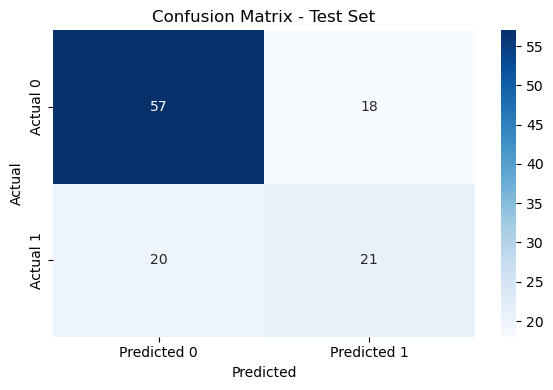


Classification Report Table:
              precision  recall  f1-score  support
0.0                0.74    0.76      0.75    75.00
1.0                0.54    0.51      0.52    41.00
accuracy           0.67    0.67      0.67     0.67
macro avg          0.64    0.64      0.64   116.00
weighted avg       0.67    0.67      0.67   116.00
📊 Confusion matrix plot saved as 'confusion_matrix_test.png'


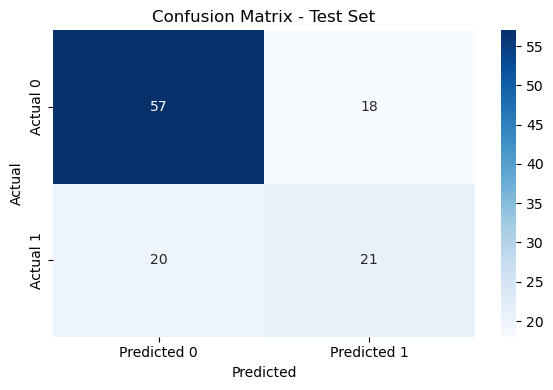

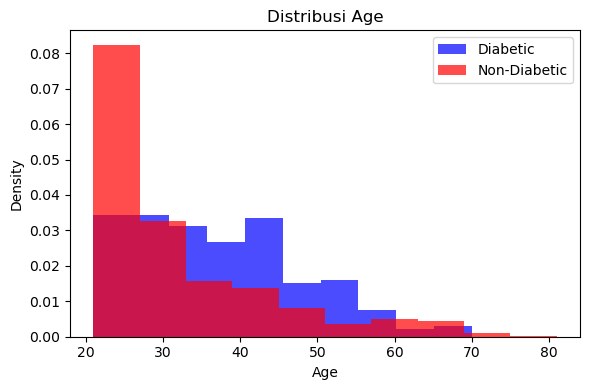

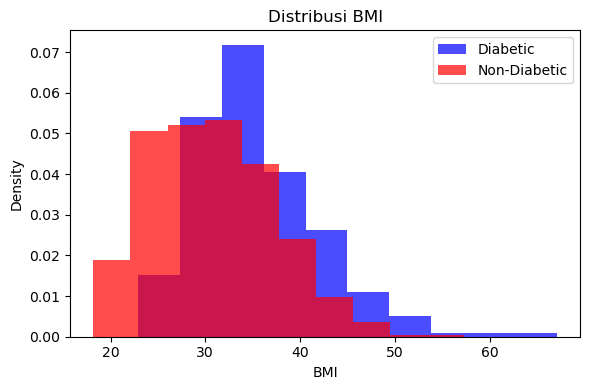

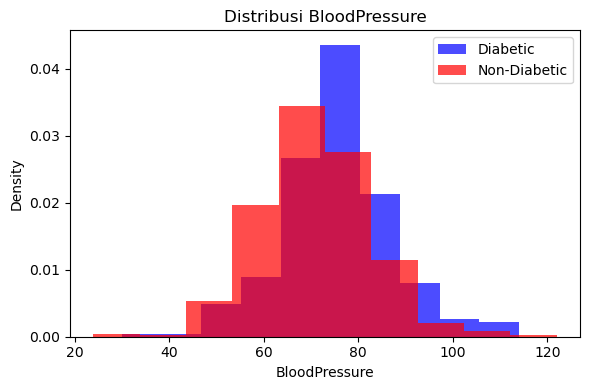

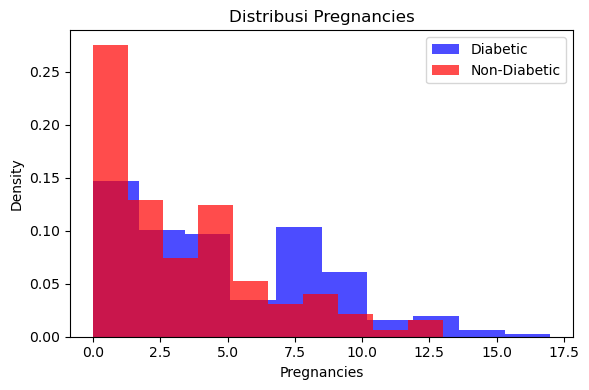

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("diabetes.csv")

# Gunakan hanya 4 fitur terpilih
selected_features = ['Age', 'BMI', 'BloodPressure', 'Pregnancies', 'Outcome']
df = df[selected_features]

# Handle missing values - ganti 0 dengan NaN hanya untuk kolom yang masih masuk
zero_not_accepted = ['BloodPressure', 'BMI']
for column in zero_not_accepted:
    df[column] = df[column].replace(0, np.nan)

df = df.fillna(df.median())  # Imputasi dengan median

print("Dataset shape:", df.shape)
print("Class distribution:", df['Outcome'].value_counts())

X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Original split - Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")

train = pd.DataFrame(np.column_stack([X_train, y_train]), columns=selected_features)
valid = pd.DataFrame(np.column_stack([X_valid, y_valid]), columns=selected_features)
test = pd.DataFrame(np.column_stack([X_test, y_test]), columns=selected_features)

def scale_dataset(dataframe, scaler=None, oversample=False):
    x = dataframe.drop("Outcome", axis=1).values
    y = dataframe["Outcome"].values
    
    if scaler is None:
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)
    
    if oversample:
        count = Counter(y)
        print(f"Before SMOTE - Class distribution: {count}")
        
        min_class_count = min(count.values())
        if min_class_count > 5:
            k_neighbors = min(5, min_class_count - 1)
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy='auto')
            x, y = smote.fit_resample(x, y)
            print(f"✅ SMOTE diterapkan - New class distribution: {pd.Series(y).value_counts().to_dict()}")
        else:
            print("⚠ Jumlah data kelas minoritas terlalu sedikit. SMOTE dilewati.")
    
    data = np.hstack((x, np.reshape(y, (-1, 1))))
    return data, x, y, scaler

# Preprocessing
train_data, x_train, y_train, scaler = scale_dataset(train, oversample=True)
valid_data, x_valid, y_valid, _ = scale_dataset(valid, scaler=scaler, oversample=False)
test_data, x_test, y_test, _ = scale_dataset(test, scaler=scaler, oversample=False)

print(f"After preprocessing - Train: {x_train.shape}, Valid: {x_valid.shape}, Test: {x_test.shape}")

# GridSearch
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

print("Mulai GridSearch...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

y_pred = best_model.predict(x_valid)
print("\n=== HASIL VALIDASI ===")
print("Accuracy validasi:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

y_test_pred = best_model.predict(x_test)
with open("test_results.txt", "w") as f:
    f.write("=== HASIL FINAL TEST ===\n")
    f.write(f"Accuracy test: {accuracy_score(y_test, y_test_pred):.4f}\n")
    f.write(classification_report(y_test, y_test_pred))
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(confusion_matrix(y_test, y_test_pred)))
print("✅ Hasil test disimpan ke 'test_results.txt'")


# Simpan model dan scaler
joblib.dump(best_model, "model_pima_rf_4fitur.pkl")
joblib.dump(scaler, "scaler_pima_4fitur.pkl")
print("✅ Model dan scaler 4 fitur berhasil disimpan.")

# Analisis tambahan
proba = best_model.predict_proba(x_test)[:, 1]
print(f"\nPrediction probabilities - Min: {proba.min():.3f}, Max: {proba.max():.3f}")

print("\n=== TIPS UNTUK HASIL YANG LEBIH BAIK ===")
print("1. Coba random_state berbeda")
print("2. Gunakan StratifiedKFold")
print("3. Coba XGBoost atau LightGBM")
print("4. Ubah threshold klasifikasi (bukan default 0.5)")

import seaborn as sns

# Confusion Matrix as DataFrame
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("\nConfusion Matrix Table:")
print(cm_df)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# Classification Report as DataFrame
report_dict = classification_report(y_test, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print("\nClassification Report Table:")
print(report_df.round(2))

# Optional: save plot to file
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
print("📊 Confusion matrix plot saved as 'confusion_matrix_test.png'")

# Simpan histogram distribusi fitur ke file PNG
cols = ['Age', 'BMI', 'BloodPressure', 'Pregnancies']

for col in cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[df["Outcome"] == 1][col], color='blue', label='Diabetic', alpha=0.7, density=True)
    plt.hist(df[df["Outcome"] == 0][col], color='red', label='Non-Diabetic', alpha=0.7, density=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{col}_distribution.png")  # Simpan sebagai PNG
    plt.show()

